# EDA Project: King County Housing Data
### Markus Baden
Stakeholder: **Amy Williams**
* Seller and buyer
* Italian mafiosi
* sells several central houses(top10%) over time
* needs average outskirt houses over time to hide from the FBI

### Data import from PostgreSQL database

In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import geopy.distance

In [40]:
plt.rcParams.update({ "figure.figsize" : (8, 6)})

In [41]:
#read the database string from the .env
load_dotenv()
DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

# join house_details with house_sales and import to dataframe
query_string = ("SELECT * " + 
                "FROM eda.king_county_house_sales s " + 
                "INNER JOIN eda.king_county_house_details d " + 
                "ON s.house_id = d.id")
df_housing = pd.read_sql(query_string, db)

### Data cleaning

In [44]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   id             21597 non-null  int64  
 5   bedrooms       21597 non-null  float64
 6   bathrooms      21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   sqft_lot       21597 non-null  float64
 9   floors         21597 non-null  float64
 10  waterfront     19206 non-null  float64
 11  view           21534 non-null  float64
 12  condition      21597 non-null  int64  
 13  grade          21597 non-null  int64  
 14  sqft_above     21597 non-null  float64
 15  sqft_basement  21145 non-null  float64
 16  yr_built       21597 non-null  int64  
 17  yr_renovated   17749 non-null  float64
 18  zipcod

In [45]:
# drop unnecessary id column
df_housing.drop('id', axis=1, inplace=True)
df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,...,6,770.0,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,...,7,1050.0,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,...,8,1680.0,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0


In [46]:
df_housing.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [47]:
df_housing.waterfront.unique()

array([nan,  0.,  1.])

In [48]:
df_housing.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [49]:
df_housing.dtypes

date              object
price            float64
house_id           int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

Assumptions for filling missing values with 0: 
* 'waterfront': houses at the waterfront would likely have data here, since it is an important selling point
* 'view': houses with a view better that 0 would also likely have data here, since it is an important selling point
* 'sqft_basement': houses with a basement would likely have data here, since it is an important selling point

In [50]:
# change date format from string to datetime
df_housing['date'] = pd.to_datetime(df_housing['date'], format='%Y/%m/%d')

# correct faulty year renovated values and fill NaNs with 0
df_housing['yr_renovated'] = df_housing.yr_renovated.apply(lambda x: (x/10))
df_housing.yr_renovated.fillna(0, inplace=True)

# fill NaN with 0 for 'waterfront', 'view' and 'sqft_basement' columns
df_housing.waterfront.fillna(0, inplace=True)
df_housing.view.fillna(0, inplace=True)
df_housing.sqft_basement.fillna(0, inplace=True)

In [51]:
# change data types of several columns to int
df_housing = df_housing.astype({'price': int, 
                                'bedrooms': int, 
                                'sqft_living': int, 
                                'sqft_lot': int, 
                                'waterfront': int, 
                                'view': int, 
                                'sqft_above':int, 
                                'sqft_basement': int, 
                                'yr_renovated': int,
                                'sqft_living15': int,
                                'sqft_lot15': int
                                })

In [52]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  int64         
 2   house_id       21597 non-null  int64         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  int64         
 9   view           21597 non-null  int64         
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  int64         
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

In [53]:
df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900,7129300520,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000,6414100192,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000,5631500400,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000,2487200875,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000,1954400510,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


The dataset is cleaned. There are no more missing values and the data types are sensible.

### Overview of the dataset


In [54]:
# calculate price per sqft as basis for further analysis
df_housing['usd_per_sqft'] = df_housing.price / df_housing.sqft_living

In [55]:
# Seattle city center coordinates as point of reference
seattle_center = (47.608013, -122.335167)

# add distance from city center in miles to dataframe
df_housing['coords'] = list(zip(df_housing.lat, df_housing.long))
df_housing['distance'] = df_housing.coords.apply(lambda x: geopy.distance.geodesic(seattle_center, x).miles )

df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,usd_per_sqft,coords,distance
0,2014-10-13,221900,7129300520,3,1.00,1180,5650,1.0,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,188.050847,"(47.5112, -122.257)",7.622036
1,2014-12-09,538000,6414100192,3,2.25,2570,7242,2.0,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,209.338521,"(47.721, -122.319)",7.842246
2,2015-02-25,180000,5631500400,2,1.00,770,10000,1.0,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,233.766234,"(47.7379, -122.233)",10.161211
3,2014-12-09,604000,2487200875,4,3.00,1960,5000,1.0,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,308.163265,"(47.5208, -122.393)",6.604160
4,2015-02-18,510000,1954400510,3,2.00,1680,8080,1.0,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,303.571429,"(47.6168, -122.045)",13.569108


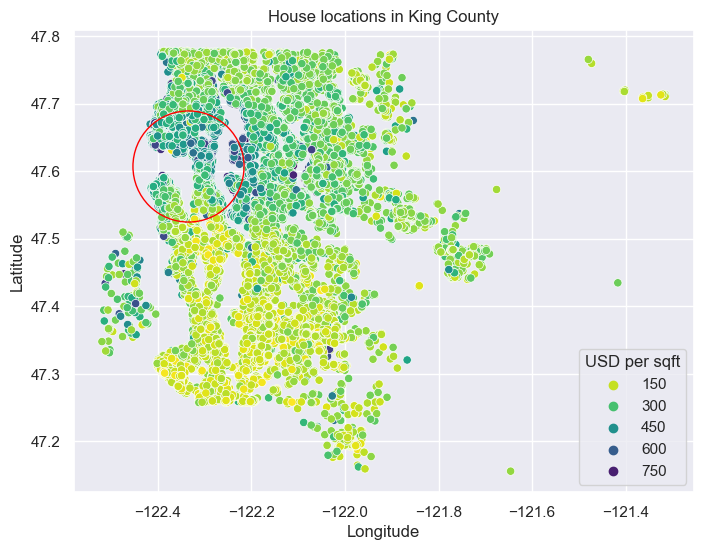

In [86]:
# Plot all houses and mark circle at approximately 6 miles from Seattle city center
fig = sns.scatterplot(data=df_housing, x='long', y='lat', hue='usd_per_sqft', palette="viridis_r")
fig.plot([seattle_center[1]],[seattle_center[0]],'o',ms=80,mec='r',mfc='none')
fig.set(xlabel='Longitude', ylabel='Latitude', title='House locations in King County')
fig.legend(title='USD per sqft')
plt.show()

### Finding possible hideout houses

#### What is the typical house in the outskirts of the city?
We'll choose a distance of 6 miles (approx. 10km) from the city center as the border between a house being **central** or in the **outskirts**.

In [58]:
df_housing.where(df_housing.distance > 6).median()

price            4.190000e+05
house_id         3.904980e+09
bedrooms         3.000000e+00
bathrooms        2.250000e+00
sqft_living      1.990000e+03
sqft_lot         8.560000e+03
floors           1.000000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
sqft_above       1.650000e+03
sqft_basement    0.000000e+00
yr_built         1.978000e+03
yr_renovated     0.000000e+00
zipcode          9.805200e+04
lat              4.753850e+01
long            -1.221810e+02
sqft_living15    1.940000e+03
sqft_lot15       8.400000e+03
usd_per_sqft     2.204724e+02
distance         1.261052e+01
dtype: float64

#### The 'average' (median) house in the outskirts (more than 6 miles from the center) looks like this: 
* built in 1978 and never renovated
* 3 bedrooms and 2.25 bathrooms
* 1 floor
* 2000 sq.ft. living area
* 8500 sq.ft. lot size
* no basement
* condition 3
* grade 7
* no view and not located at the waterfront

#### Next step: looking for houses that are similar to this
We choose the following ranges, where exact matching of the criteria is not possible:
* year of building between 1977 and 1979
* living area between 1800 and 2200 sq.ft.
* lot size between 6000 and 11000 sq.ft.

In [59]:
# collect houses that are like the median house
hideouts = df_housing.where((df_housing.distance > 6) & 
                    (df_housing.sqft_living > 1800) & 
                    (df_housing.sqft_living < 2200) & 
                    (df_housing.sqft_lot > 6000) & 
                    (df_housing.sqft_lot < 11000) & 
                    (df_housing.yr_built >= 1977) & 
                    (df_housing.yr_built <= 1979) & 
                    (df_housing.yr_renovated == 0) & 
                    (df_housing.bedrooms == 3) & 
                    (df_housing.bathrooms == 2.25) & 
                    (df_housing.floors == 1) & 
                    (df_housing.condition == 3) & 
                    (df_housing.grade == 7) & 
                    (df_housing.view == 0) & 
                    (df_housing.waterfront == 0)
                    ).dropna().copy()
# drop unnecessary columns
hideouts.drop(['yr_renovated', 
                'bedrooms', 
                'bathrooms', 
                'condition', 
                'grade', 
                'view', 
                'waterfront', 
                'coords', 
                'floors', 
                'sqft_above'], 
                axis=1, 
                inplace=True)
hideouts = hideouts.astype({'price':int, 
                            'house_id':int, 
                            'sqft_living':int, 
                            'sqft_lot':int, 
                            'sqft_basement':int, 
                            'yr_built':int,
                            'zipcode':int, 
                            'sqft_living15':int, 
                            'sqft_lot15':int})
hideouts.reset_index(drop=True, inplace=True)
# Show results
hideouts

,date,price,house_id,sqft_living,sqft_lot,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,usd_per_sqft,distance
0,2015-02-02,431000,8651720060,1830,8831,370,1979,98034,47.7286,-122.215,2330,8064,235.519126,10.042481
1,2015-02-18,162000,9211500730,1810,6750,530,1978,98023,47.2976,-122.377,1690,7770,89.502762,21.533927
2,2015-03-30,531000,8651730580,1910,8390,0,1979,98034,47.7300,-122.216,2410,8390,278.010471,10.097044
3,2014-06-03,425000,6204420180,1870,9000,430,1978,98011,47.7373,-122.198,1870,8640,227.272727,10.988522
4,2015-02-05,485000,4024101990,2090,7450,740,1978,98155,47.7598,-122.303,1740,7644,232.057416,10.593287
5,2015-03-23,415000,2561330040,1820,9694,580,1977,98074,47.6157,-122.050,1820,9694,228.021978,13.332661
6,2014-12-11,300000,2143700406,2000,7560,600,1979,98055,47.4798,-122.228,2040,6949,150.000000,10.177760


These conditions lead us to finding a total of 7 possible houses for the stakeholder to buy. We can also see that all of them are in neighborhoods with similar house sizes and also similar lot sizes. 

nr. | date	| price	|house_id	|sqft_living	|sqft_lot	|sqft_basement	|yr_built	|lat	|long	|sqft_living15	|sqft_lot15	|distance	|usd_per_sqft
---|---|---|---|---|---|---|---|---|---|---|---|---|---
0	|2015-02-02	|431000	|8651720060	|1830	|8831	|370.000	|1979	|47.729	|-122.215	|2330	|8064	|10.042	|235.519
1	|2015-02-18	|162000	|9211500730	|1810	|6750	|530.000	|1978	|47.298	|-122.377	|1690	|7770	|21.534	|89.503
2	|2015-03-30	|531000	|8651730580	|1910	|8390	|0.000	    |1979	|47.730	|-122.216	|2410	|8390	|10.097	|278.010
3	|2014-06-03	|425000	|6204420180	|1870	|9000	|430.000	|1978	|47.737	|-122.198	|1870	|8640	|10.989	|227.273
4	|2015-02-05	|485000	|4024101990	|2090	|7450	|740.000	|1978	|47.760	|-122.303	|1740	|7644	|10.593	|232.057
5	|2015-03-23	|415000	|2561330040	|1820	|9694	|580.000	|1977	|47.616	|-122.050	|1820	|9694	|13.333	|228.022
6	|2014-12-11	|300000	|2143700406	|2000	|7560	|600.000	|1979	|47.480	|-122.228	|2040	|6949	|10.178	|150.000

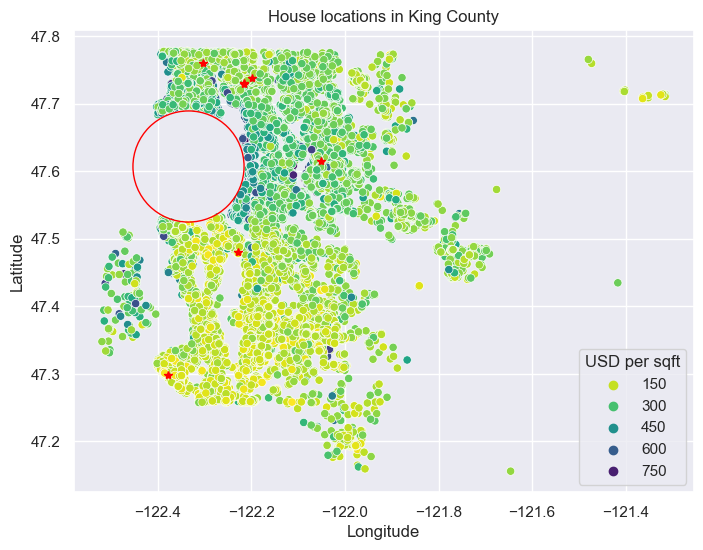

In [87]:
fig = sns.scatterplot(data=df_housing.where(df_housing.distance > 6), x='long', y='lat', hue='usd_per_sqft', palette="viridis_r")
fig.plot([seattle_center[1]],[seattle_center[0]],'o',ms=80,mec='r',mfc='none')
for _, row in hideouts.iterrows():
    fig.plot(row['long'], row['lat'],'r*')
fig.set(xlabel='Longitude', ylabel='Latitude', title='House locations in King County')
fig.legend(title='USD per sqft')
x_limit = fig.get_xlim()
y_limit = fig.get_ylim()
plt.show()

### Best timing for buying and selling

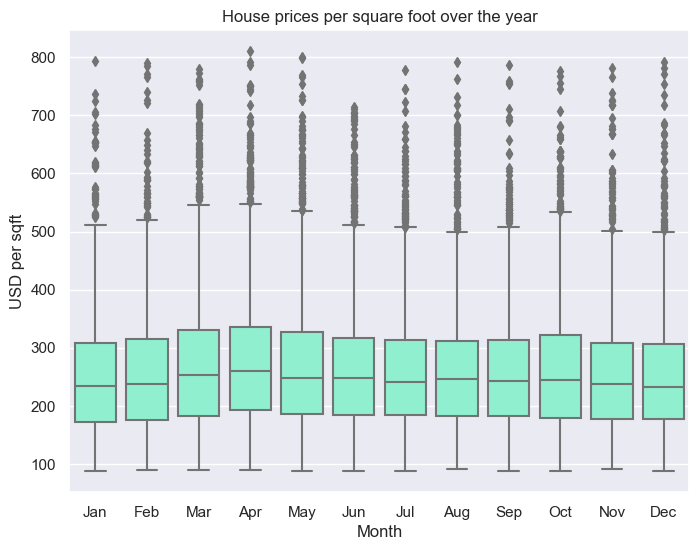

In [90]:
# plot house prices per sqft for each month
fig = sns.boxplot( x=df_housing.date.dt.month, y=df_housing["usd_per_sqft"], color="aquamarine");
fig.set(xlabel='Month', ylabel='USD per sqft', title='House prices per square foot over the year')
fig.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])   
plt.show()

**Recommendations for the stakeholder:**
* Buy in winter (December and January)
* Sell in spring (April)


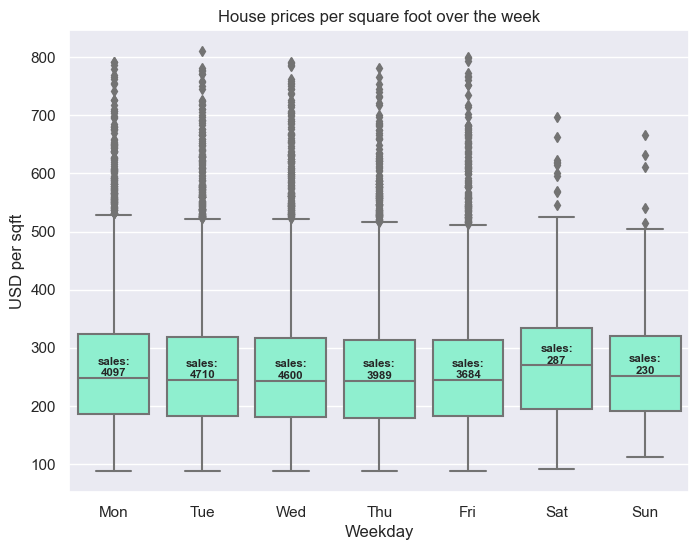

In [93]:
# plot house prices per sqft for each month
fig = sns.boxplot( x=df_housing.date.dt.weekday, y=df_housing["usd_per_sqft"], color="aquamarine");
fig.set(xlabel='Weekday', ylabel='USD per sqft', title='House prices per square foot over the week')
fig.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])            

# Calculate number of sales per weekday & median to position labels
medians = df_housing.groupby(df_housing.date.dt.weekday)['usd_per_sqft'].median().values
nos = df_housing.date.dt.weekday.value_counts().sort_index().values
nos = [str(x) for x in nos.tolist()]
nos = ["sales:\n" + i for i in nos]
# Add number of sales to the plot
pos = range(len(nos))
for tick,label in zip(pos,fig.get_xticklabels()):
    fig.text(pos[tick],
            medians[tick] ,
            nos[tick],
            horizontalalignment='center',
            verticalalignment='bottom',
            size='x-small',
            weight='semibold')

plt.show()

**Recommendations for the stakeholder:**
* Buy in the middle of the week (Wednesday or Thursday)
* Sell on Saturdays


The number of sales on Saturdays is only 5% to 6% of the number of sales on each weekday. The higher prices on Saturdays could also have other reasons.

### Timing for high value sales

In [84]:
high_value_sales = df_housing.where((df_housing.distance < 6) & 
                                    (df_housing.price > df_housing.price.quantile(0.9))
                                    ).dropna().copy()
high_value_sales.shape

(871, 24)

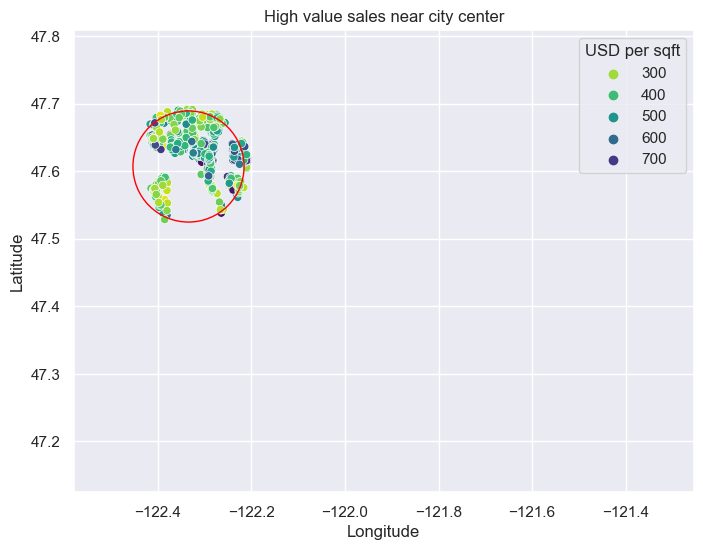

In [85]:
fig = sns.scatterplot(data=high_value_sales, x='long', y='lat', hue='usd_per_sqft', palette="viridis_r")
fig.plot([seattle_center[1]],[seattle_center[0]],'o',ms=80,mec='r',mfc='none')
fig.set_xlim(x_limit)
fig.set_ylim(y_limit)
fig.set(xlabel='Longitude', ylabel='Latitude', title='High value sales near city center')
fig.legend(title='USD per sqft')
plt.show()

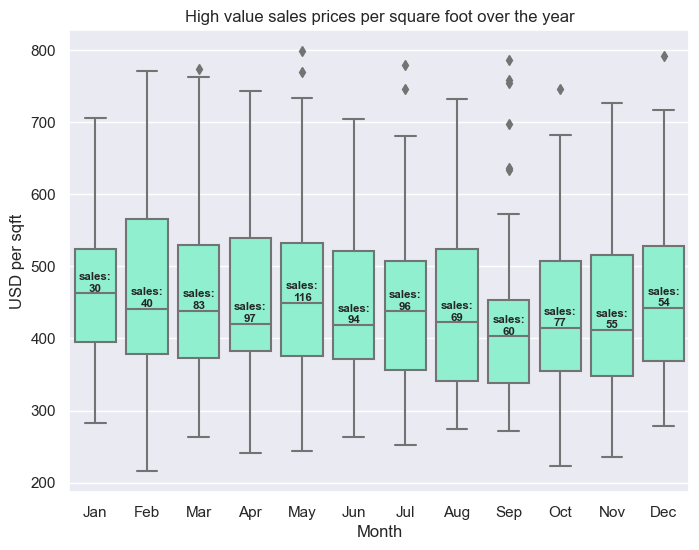

In [95]:
fig = sns.boxplot( x=high_value_sales.date.dt.month, y=high_value_sales["usd_per_sqft"], color="aquamarine");
fig.set(xlabel='Month', ylabel='USD per sqft', title='High value sales prices per square foot over the year')
fig.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])   

# Calculate number of sales per weekday & median to position labels
medians = high_value_sales.groupby(df_housing.date.dt.month)['usd_per_sqft'].median().values
nos = high_value_sales.date.dt.month.value_counts().sort_index().values
nos = [str(x) for x in nos.tolist()]
nos = ["sales:\n" + i for i in nos]
# Add number of sales to the plot
pos = range(len(nos))
for tick,label in zip(pos,fig.get_xticklabels()):
    fig.text(pos[tick],
            medians[tick] ,
            nos[tick],
            horizontalalignment='center',
            verticalalignment='bottom',
            size='x-small',
            weight='semibold')

plt.show()

* Sales of high value houses near the city center are rare
* The variance for these sales is much higher
* No specific recommendation for timing can be given
